### Reading the csv file

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("fraud-detection").getOrCreate()

df = spark.read.csv("onlinefraud.csv", header=True, inferSchema=True)
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [3]:
#df.printSchema()

print("Number of rows: ", df.count())
print("Number of cols: ", len(df.columns))

Number of rows:  6362620
Number of cols:  11


### Feautres in the dataset and their information:

- oldbalanceOrg: represents a unit of time where 1 oldbalanceOrg equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction

In [4]:
print(df.first())

Row(step=1, type='PAYMENT', amount=9839.64, nameOrig='C1231006815', oldbalanceOrg=170136.0, newbalanceOrig=160296.36, nameDest='M1979787155', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0)


In [5]:
from pyspark.sql.functions import col, sum as _sum

df.select(*[_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [6]:
num_rows_before = df.count()

num_rows_after = df.dropDuplicates().count()

num_duplicated_rows = num_rows_before - num_rows_after

print("Number of duplicated rows: ", num_duplicated_rows)

Number of duplicated rows:  0


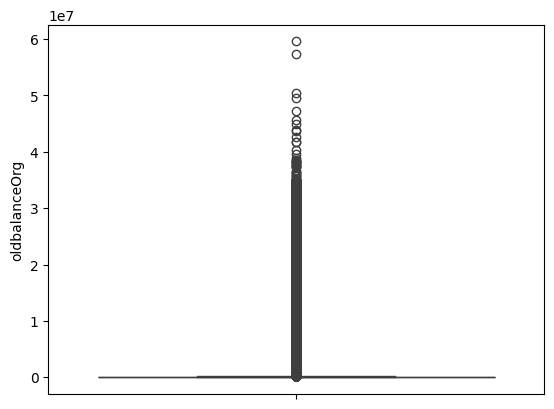

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

oldBalanceOrg_data = df.select("oldbalanceOrg").toPandas()

sns.boxplot(oldBalanceOrg_data['oldbalanceOrg'])
plt.show()

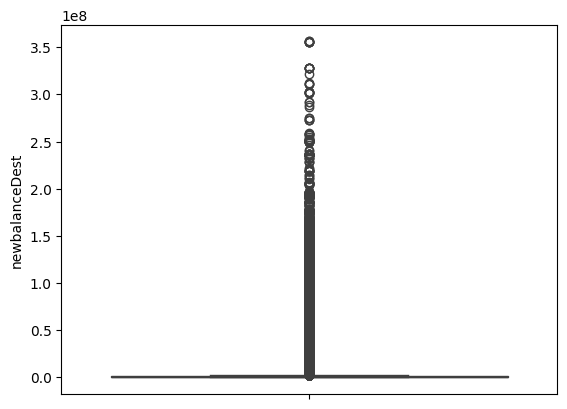

In [8]:
newbalanceDest_data = df.select("newbalanceDest").toPandas()

sns.boxplot(newbalanceDest_data["newbalanceDest"])
plt.show()

Making a correlation matrix

In [9]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# List of column names that are numeric
numeric_cols = [col for col, dtype in df.dtypes if dtype in ['double', 'int', 'bigint', 'float', 'decimal']]

# Convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.00000000e+00,  2.23729947e-02, -1.00583784e-02, -1.02990370e-02,
        2.76653596e-02,  2.58881757e-02,  3.15775686e-02,  3.27741539e-03,
        2.23729947e-02,  1.00000000e+00, -2.76247476e-03, -7.86092529e-03,
        2.94137450e-01,  4.59304267e-01,  7.66884288e-02,  1.22946025e-02,
       -1.00583784e-02, -2.76247476e-03,  1.00000000e+00,  9.98802763e-01,
        6.62425013e-02,  4.20286188e-02,  1.01544219e-02,  3.83453099e-03,
       -1.02990370e-02, -7.86092529e-03,  9.98802763e-01,  1.00000000e+00,
        6.78115181e-02,  4.18374971e-02, -8.14816127e-03,  3.77606222e-03,
        2.76653596e-02,  2.94137450e-01,  6.62425013e-02,  6.78115181e-02,
        1.00000000e+00,  9.76568505e-01, -5.88527823e-03, -5.13497135e-04,
        2.58881757e-02,  4.59304267e-01,  4.20286188e-02,  4.18374971e-02,
        9.76568505e-01,  1.00000000e+00,  5.35347068e-04, -5.28716661e-04,
        3.15775686e-02,  7.66884288e-02,  1.01544219e-02, -8.14816127e-03,
       -5.88527823e-03,  

Checking the interquartile range

In [10]:
# Compute the 25th and 75th percentiles
Q1 = df.approxQuantile("amount", [0.25], 0)[0]
Q3 = df.approxQuantile("amount", [0.75], 0)[0]

# Compute the interquartile range (IQR)
IQR = Q3 - Q1

print(IQR)

195331.88


In [11]:
upper = Q3 +1.5*IQR
lower = Q1 - 1.5*IQR

In [12]:
from pyspark.sql.functions import when

# Create new columns 'upper' and 'lower' based on conditions
df = df.withColumn('upper', when(df['amount'] >= (Q3 + 1.5 * IQR), True).otherwise(False))
df = df.withColumn('lower', when(df['amount'] <= (Q1 - 1.5 * IQR), True).otherwise(False))

# Exclude rows where 'upper' or 'lower' is True
df = df.filter(~df['upper'] & ~df['lower'])

In [13]:
step_data = df.select("step")
print(step_data)

DataFrame[step: int]


### Exploratory Data Analysis

In [14]:
column_names = df.columns
print(column_names)

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'upper', 'lower']


In [15]:
unique_types = df.select("type").distinct()

unique_types_list = [row['type'] for row in unique_types.collect()]

print(unique_types_list)

['TRANSFER', 'CASH_IN', 'CASH_OUT', 'PAYMENT', 'DEBIT']


In [17]:
from pyspark.sql.functions import desc

type_counts = df.groupBy("type").count().sort(desc("count")).collect()

# Convert to list of tuples
type_counts_list = [(row['type'], row['count']) for row in type_counts]

# Print the list of tuples
for type, count in type_counts_list:
    print(f"{type}: {count}")

CASH_OUT: 2185249
PAYMENT: 2151495
CASH_IN: 1373826
TRANSFER: 272542
DEBIT: 41430


C:\Users\Kabeer Yosaf\AppData\Local\Temp\ipykernel_138552\1973519616.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=types, y=counts, palette="pastel")


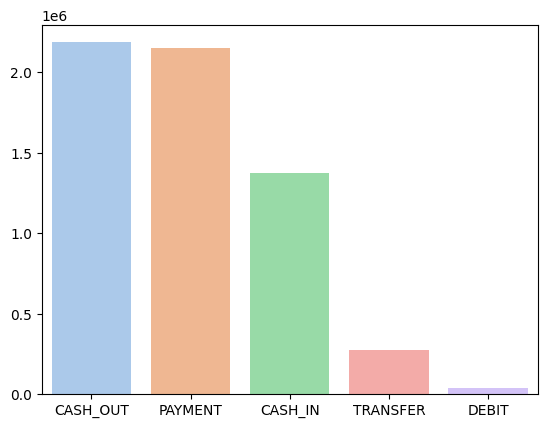

In [19]:
import seaborn as sb

type_counts = df.groupBy("type").count().sort(desc("count"))

type_counts_list = [(row['type'], row['count']) for row in type_counts.collect()]

types = [type for type, count in type_counts_list]
counts = [count for type, count in type_counts_list]

# Create the bar plot
sb.barplot(x=types, y=counts, palette="pastel")
plt.show()

It looks like that cash out takes the most of the data and then payment so we can conclude that the most of fraud will b e in this two types

In [20]:
summary = df.describe()
summary.show()

+-------+------------------+--------+------------------+-----------+------------------+------------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|            amount|   nameOrig|     oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+------------------+-----------+------------------+------------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6024542| 6024542|           6024542|    6024542|           6024542|           6024542|    6024542|           6024542|           6024542|             6024542|             6024542|
|   mean|243.31261098354034|    NULL|111534.18030262447|       NULL| 861957.9410389633| 885912.9946142983|       NULL| 987126.4764098587|1037882.8598196896|7.235404782637419E-4|3.319754431125221E-7|
| std

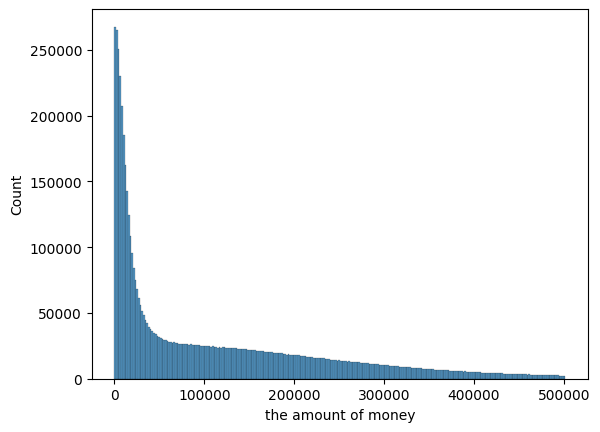

In [21]:
import pandas as pd

pandas_df = df.select("amount").toPandas()

sb.histplot(pandas_df['amount'])
plt.xlabel('the amount of money')
plt.show()

- Top 10 largest amount

In [22]:
top_10 = df.orderBy(df['amount'].desc()).limit(10)
top_10.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-----+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|upper|lower|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-----+
| 161|CASH_OUT|501718.41|C1077569708|      78605.0|           0.0|C1924590813|     697311.14|    1199029.56|      0|             0|false|false|
| 129| CASH_IN|501718.02| C970634468| 2.08731403E7| 2.137485832E7|C1091756447|    5463193.08|    5127569.29|      0|             0|false|false|
| 226|CASH_OUT|501717.55| C855812747|     121947.7|           0.0| C914557298|    1379104.08|    1880821.63|      0|             0|false|false|
| 181| CASH_IN|501717.33| C897630635|   5120317.65|    5622034.98|C1830915224|    1314756.05|     813038.72|      0|             0|false

In [23]:
from pyspark.sql.functions import desc, monotonically_increasing_id
from pyspark.sql import Window

df = df.withColumn("index", monotonically_increasing_id())

top_10 = df.orderBy(desc('amount')).limit(10)

x = top_10.select('index', 'type')

x.show()

+-----------+--------+
|      index|    type|
+-----------+--------+
| 8590051412|CASH_OUT|
|    1024577| CASH_IN|
| 8591093067|CASH_OUT|
| 8590366658| CASH_IN|
|25770239577|CASH_OUT|
| 8591239422| CASH_IN|
| 8589958280| CASH_IN|
| 8590325717| CASH_IN|
|     776126|TRANSFER|
|      55213|CASH_OUT|
+-----------+--------+



- In the largets 100 amount of money it's safe and from that we can conclude that the largest amount of money the transaction nearly has more security than small amounts of money

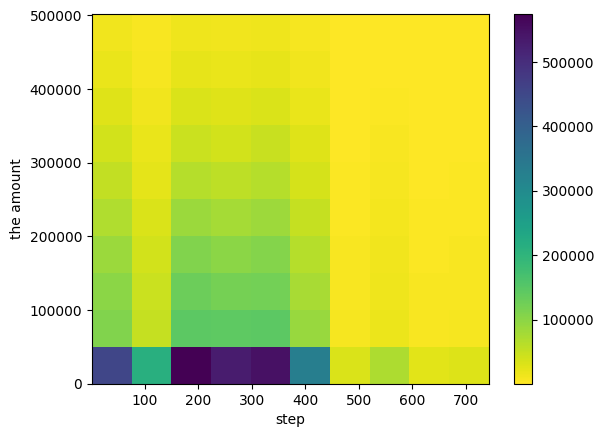

In [24]:
pandas_df = df.select("step", "amount").toPandas()

plt.hist2d(x=pandas_df['step'], y=pandas_df['amount'], cmin=0.5, cmap='viridis_r')
plt.colorbar()
plt.xlabel('step')
plt.ylabel('the amount')
plt.show()

- The nameOrig is the client IDs

In [25]:
unique_count = df.select("nameOrig").distinct().count()
total_count = df.count()

percentage = round((unique_count * 100) / total_count, 2)

print(f'the number of unique values of nameOrig is : {percentage} %')

the number of unique values of nameOrig is : 99.86 %


In [26]:
from pyspark.sql.functions import col, expr

df = df.withColumn("nameOrig", expr("substring(nameOrig, 2, length(nameOrig))").cast("int"))
df = df.withColumnRenamed("nameOrig", "client_id")

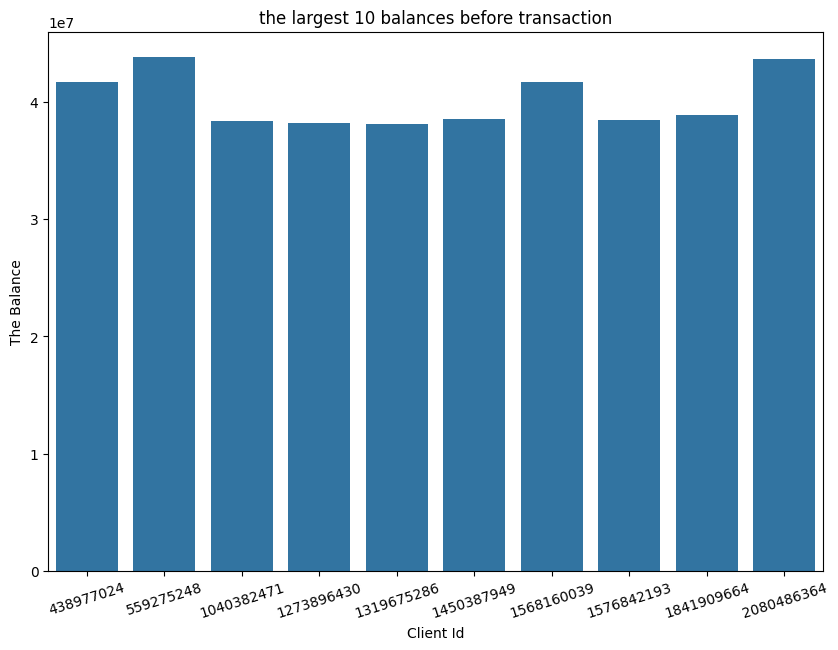

In [27]:

top_10 = df.orderBy(desc('oldbalanceOrg')).limit(10).toPandas()

plt.figure(figsize = [10,7])
sb.barplot(x = top_10['client_id'], y = top_10['oldbalanceOrg'])
plt.xticks(rotation = 17.5)
plt.title('the largest 10 balances before transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

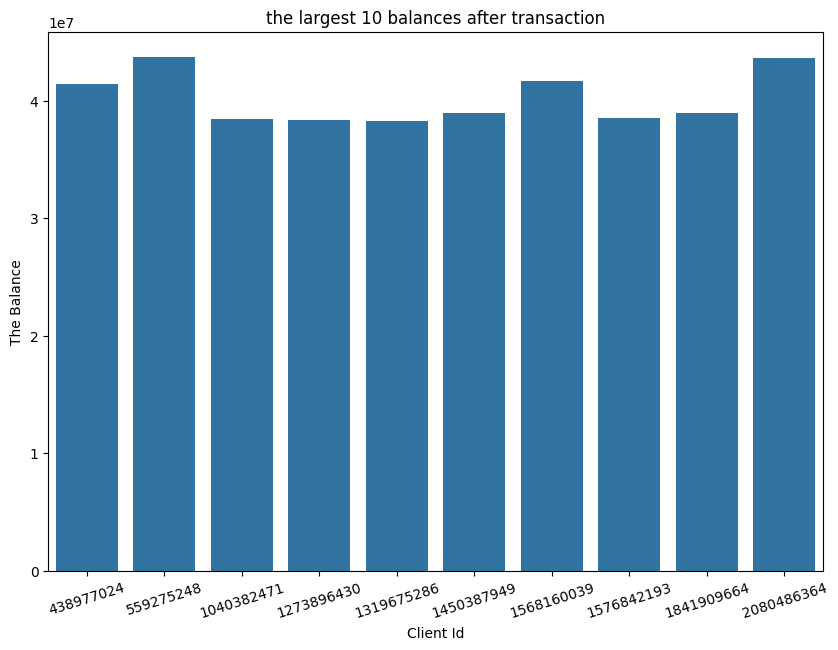

In [28]:
top_10 = df.orderBy(desc('newbalanceOrig')).limit(10).toPandas()

plt.figure(figsize = [10,7])
sb.barplot(x = top_10['client_id'], y = top_10['newbalanceOrig'])
plt.xticks(rotation = 17.5)
plt.title('the largest 10 balances after transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

In [44]:
df = df.withColumn("balance_diff", col("oldbalanceOrg") - col("newbalanceOrig"))

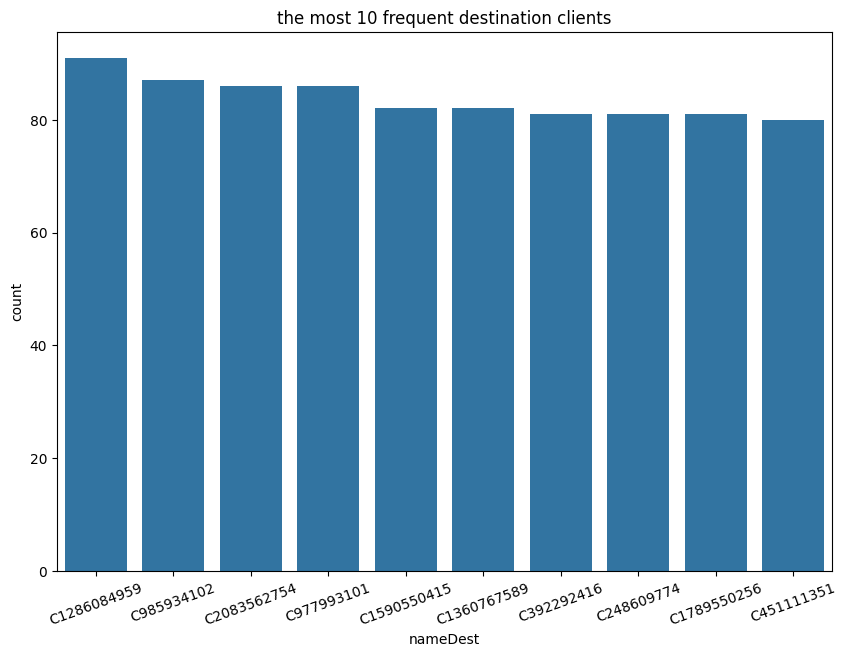

In [29]:
n = 10
top_n = df.groupBy("nameDest").count().orderBy(desc("count")).limit(n).toPandas()

plt.figure(figsize = [10,7])
sb.barplot(x = top_n['nameDest'], y = top_n['count'])
plt.xticks(rotation = 20)
plt.title('the most 10 frequent destination clients')
plt.show()

- And here we can say there's a fraud detection because some destination clients like the first one which has 92 transaction some thing may be wrong here and so on

- For the destination client id C1286084959 let's see the largest amount of money transfer and is fraud or not

In [30]:
filtered_df = df.filter(df.nameDest == 'C1286084959')
filtered_df.show()

+----+--------+---------+----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-----+-----+
|step|    type|   amount| client_id|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|upper|lower|index|
+----+--------+---------+----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-----+-----+
|   1|TRANSFER|176334.26| 169880779|      45136.0|           0.0|C1286084959|    1251626.46|    2107778.11|      0|             0|false|false|  350|
|   1|CASH_OUT|373068.26|1047934137|      20034.0|           0.0|C1286084959|    1427960.73|    2107778.11|      0|             0|false|false|  361|
|   1| CASH_IN|403418.39| 848097505|   3834666.95|    4238085.34|C1286084959|    1801028.99|    2107778.11|      0|             0|false|false|  442|
|   1| CASH_IN|222126.95| 870322840|   6688712.64|    6910839.59|C1286084959|     1397610.6|    2107778.11

- Let's see the most frequent distination client with fraud transaction cases

In [31]:
filtered_df = df.filter(df.isFraud == 1)
filtered_df.show()

+----+--------+---------+----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-----+-----+
|step|    type|   amount| client_id|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|upper|lower|index|
+----+--------+---------+----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-----+-----+
|   1|TRANSFER|    181.0|1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|false|false|    2|
|   1|CASH_OUT|    181.0| 840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|false|false|    3|
|   1|TRANSFER|   2806.0|1420196421|       2806.0|           0.0| C972765878|           0.0|           0.0|      1|             0|false|false|  241|
|   1|CASH_OUT|   2806.0|2101527076|       2806.0|           0.0|C1007251739|       26202.0|           0.0

In [32]:
filtered_df = df.filter(df.isFlaggedFraud == 1)
filtered_df.show()

+----+--------+---------+----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-----+-----------+
|step|    type|   amount| client_id|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|upper|lower|      index|
+----+--------+---------+----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-----+-----------+
| 586|TRANSFER|353874.22|1684585475|    353874.22|     353874.22|C1770418982|           0.0|           0.0|      1|             1|false|false|25771116349|
| 646|TRANSFER|399045.08| 724693370|1.039904508E7| 1.039904508E7|C1909486199|           0.0|           0.0|      1|             1|false|false|25771188876|
+----+--------+---------+----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-----+-----------+



In [33]:
n = 10
filtered_df = df.filter(df.isFraud == 1)
top_n = filtered_df.groupBy("nameDest").count().orderBy(desc("count")).limit(n)

top_n.show()

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C200064275|    2|
|C1185292292|    2|
| C410033330|    2|
| C935310781|    2|
| C475338087|    2|
|C1656842502|    2|
|C1325541393|    2|
| C105660024|    2|
|C1650668671|    2|
| C650699445|    2|
+-----------+-----+



In [34]:
from pyspark.sql.functions import col, translate

df = df.withColumn("nameDest", translate(col("nameDest"), "CM", ""))
df = df.withColumnRenamed("nameDest", "distination_client_id")

### Data Preprocessing

In [35]:
fraud_counts = df.groupBy("isFraud").count()
fraud_counts.show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   4359|
|      0|6020183|
+-------+-------+



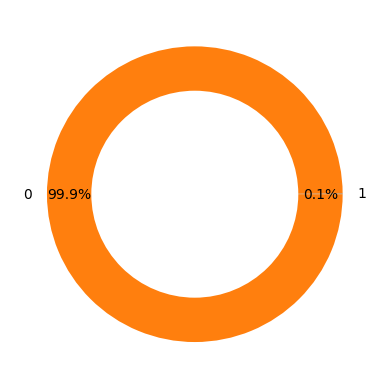

In [36]:
fraud_counts_pd = fraud_counts.toPandas()

plt.pie(fraud_counts_pd['count'], labels=fraud_counts_pd['isFraud'], autopct='%1.1f%%', pctdistance=0.85)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

- The fraud_data contains very small fraud cases (0.1%) so to avoid any missclassifications we will balance the dataset

In [37]:

class_count_0 = df.filter(df.isFraud == 0).count()
class_count_1 = df.filter(df.isFraud == 1).count()

class_0 = df.filter(df.isFraud == 0)
class_1 = df.filter(df.isFraud == 1)

print("Class 0: ", class_0.count())
print("Class 1: ", class_1.count())

Class 0:  6020183
Class 1:  4359


+-------+-----+
|isFraud|count|
+-------+-----+
|      0| 4268|
|      1| 4359|
+-------+-----+



<Axes: title={'center': 'count (target)'}, xlabel='isFraud'>

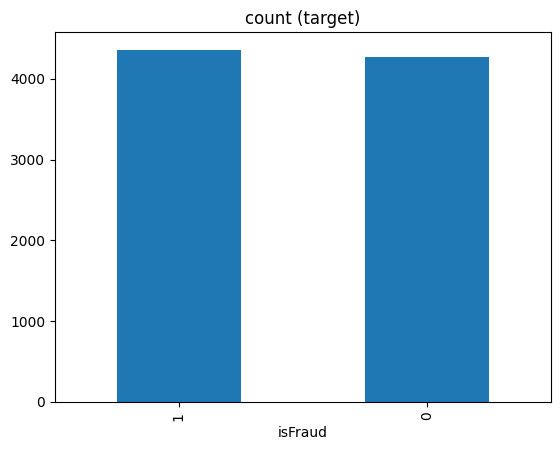

In [38]:
class_0_under = class_0.sample(withReplacement=False, fraction=class_count_1/class_0.count())

balancing_data = class_0_under.union(class_1)

balancing_data.groupBy("isFraud").count().show()
balancing_data_pd = balancing_data.toPandas()
balancing_data_pd['isFraud'].value_counts().plot(kind='bar', title='count (target)')

In [39]:
balancing_data.show(5)

+----+--------+---------+----------+-------------+--------------+---------------------+--------------+--------------+-------+--------------+-----+-----+-----+
|step|    type|   amount| client_id|oldbalanceOrg|newbalanceOrig|distination_client_id|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|upper|lower|index|
+----+--------+---------+----------+-------------+--------------+---------------------+--------------+--------------+-------+--------------+-----+-----+-----+
|   2| PAYMENT| 13330.81| 796969849|      32586.0|      19255.19|           1209462308|           0.0|           0.0|      0|             0|false|false| 3467|
|   4|CASH_OUT| 116878.6|1508667424|          0.0|           0.0|           1782113663|    1356589.82|     906564.46|      0|             0|false|false| 4579|
|   4| PAYMENT|  5630.78| 351108575|          0.0|           0.0|            143830798|           0.0|           0.0|      0|             0|false|false| 4663|
|   5| CASH_IN|258127.75| 347691330|   6193725

to include the type into our algorithm we need to mapping it

In [40]:
from pyspark.sql.functions import when

balancing_data = balancing_data.withColumn(
    "type",
    when(balancing_data["type"] == "CASH_OUT", 1)
    .when(balancing_data["type"] == "PAYMENT", 2)
    .when(balancing_data["type"] == "CASH_IN", 3)
    .when(balancing_data["type"] == "TRANSFER", 4)
    .when(balancing_data["type"] == "DEBIT", 5)
    .otherwise(balancing_data["type"])
)

### Training the model

#### Splitting the dataset

In [46]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="type", outputCol="type_indexed")

balancing_data = indexer.fit(balancing_data).transform(balancing_data)

input_cols = ['type_indexed', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'balance_diff']
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
balancing_data = assembler.transform(balancing_data)

X = balancing_data.select("features")
y = balancing_data.select("isFraud")

In [49]:
data = balancing_data.select("features", "isFraud")

train_data, test_data = data.randomSplit([0.8, 0.2], seed=0)


#### Encoding the data

In [50]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

scalerModel = scaler.fit(train_data)

train_data = scalerModel.transform(train_data)
test_data = scalerModel.transform(test_data)

In [53]:
from pyspark.ml.feature import StringIndexer

if 'label' in train_data.columns:
    train_data = train_data.drop('label')
if 'label' in test_data.columns:
    test_data = test_data.drop('label')

indexer = StringIndexer(inputCol="isFraud", outputCol="label")

indexer_model = indexer.fit(train_data)

train_data = indexer_model.transform(train_data)

test_data = indexer_model.transform(test_data)

In [54]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

models = {
    "LR": LogisticRegression(featuresCol="scaledFeatures", labelCol="label"),
    "DT": DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label"),
    "RF": RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label"),
    "GBT": GBTClassifier(featuresCol="scaledFeatures", labelCol="label")
}

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

for name, model in models.items():
    print(f'Training Model {name} \n--------------')
    model = model.fit(train_data)
    train_predictions = model.transform(train_data)
    test_predictions = model.transform(test_data)
    print(f'Training Accuracy: {evaluator.evaluate(train_predictions)}')
    print(f'Testing Accuracy: {evaluator.evaluate(test_predictions)}')
    print('-'*30)

Training Model LR 
--------------
Training Accuracy: 0.9608271443133829
Testing Accuracy: 0.9579545454545455
------------------------------
Training Model DT 
--------------
Training Accuracy: 0.981651376146789
Testing Accuracy: 0.9789772727272728
------------------------------
Training Model RF 
--------------
Training Accuracy: 0.9752439201980486
Testing Accuracy: 0.9784090909090909
------------------------------
Training Model GBT 
--------------
Training Accuracy: 0.9855832241153342
Testing Accuracy: 0.9835227272727273
------------------------------


- We're getting the best accuracy with GBT Classifier model, so we're gonna train the dataset on the GBT classifier model

In [61]:
from pyspark.ml.classification import GBTClassifier

model = GBTClassifier(featuresCol="features", labelCol="label")

model = model.fit(train_data)

print(model)

GBTClassificationModel: uid = GBTClassifier_a1f0e56ee845, numTrees=20, numClasses=2, numFeatures=5


In [62]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F


predictions = model.transform(test_data)

predictions = predictions.withColumn("prediction", F.round(predictions["prediction"]))

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.35%


In [65]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Create a DataFrame with the data you want to predict
data = [(Vectors.dense([2,9839.64,170136.0,160296.36,9839.64]),)]
df = spark.createDataFrame(data, ["features"])

# Make the prediction
predictions = model.transform(df)

# Get the first prediction
prediction = predictions.select("prediction").first()[0]

if prediction == 0:
    print('not Fraud')
else:
    print('is Fraud')

Py4JJavaError: An error occurred while calling o2327.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 843.0 failed 1 times, most recent failure: Lost task 0.0 in stage 843.0 (TID 5777) (DESKTOP-9GACIQF executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4148)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4145)
	at sun.reflect.GeneratedMethodAccessor211.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more
